# Imports

In [1]:
IMPORT_FRESH_ONLY = True # re-import all if False

SELF_TEST = True

TEST_DOC_ID = '61408a6a11c893efc81ddc94'

In [2]:
import logging
import platform
import sys
import os
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
from datetime import datetime
import tensorflow as tf

logger = logging.getLogger('retrain_ipynb')
logger.setLevel(logging.DEBUG)


ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(levelname)s - %(asctime)s - %(name)s - %(message)s')
ch.setFormatter(formatter)
logger.addHandler(ch)
logger.debug('--=logging started=--')

print(tf.__version__)
CPU = platform.processor()
print (f'Running on CPU:{CPU}')

DEBUG - 2021-09-14 23:21:50,398 - retrain_ipynb - --=logging started=--


2.5.0
Running on CPU:arm


In [3]:
nb_dir = os.path.split(os.getcwd())[0]

if nb_dir not in sys.path:
    sys.path.append(nb_dir)

import analyser.hyperparams 
analyser.hyperparams.__file__

Nemoware Analyser v2.4.6
USING WORKDIR: [/Users/artem/work/nemo/work]
 set ENV GPN_WORK_DIR to override
datasets_dir: [/Users/artem/work/nemo/work/datasets]
reports_dir: [/Users/artem/work/nemo/work/reports]


/Users/artem/work/nemo/analyser/analyser/hyperparams.py:15: UserWarning: please set GPN_WORK_DIR environment variable
  warnings.warn('please set GPN_WORK_DIR environment variable')


'/Users/artem/work/nemo/analyser/analyser/hyperparams.py'

### Prepare workdir

In [4]:
# from pathlib import Path
# _work_dir_default = Path(analyser.hyperparams.__file__).parent.parent.parent / 'work'
# work_dir = os.environ.get('GPN_WORK_DIR', _work_dir_default)

# if not os.path.isdir(work_dir):
#     os.mkdir(work_dir)

# analyser.hyperparams.work_dir = work_dir
 

# print('work_dir=', analyser.hyperparams.work_dir)
# assert os.path.isdir(analyser.hyperparams.work_dir)

### Imports...

In [5]:
%matplotlib inline

import pandas as pd
from pandas import DataFrame

from analyser.finalizer import get_doc_by_id
from analyser.persistence import DbJsonDoc
from integration.db import get_mongodb_connection
from pymongo import ASCENDING

HyperParameters.subsidiary_name_match_min_jaro_similarity 0.9629629629629629


In [6]:

db = get_mongodb_connection()
documents_collection = db['documents']

 

DB HOST IS: localhost


/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)
/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_PORT environment variable! defaulting to 27017
  warnings.warn(msg)


## Embeddings

In [7]:
from tf_support.embedder_elmo import ElmoEmbedder

embedder = ElmoEmbedder.get_instance()


In [8]:

mean_len = 400

In [9]:
from analyser.hyperparams import models_path
models_path

'/Users/artem/work/nemo/analyser/analyser/vocab'

# Analysing sample doc

In [10]:
import numpy as np
from pathlib import Path
from bson import ObjectId
from sklearn.metrics import pairwise_distances


centroids = np.load(Path(models_path) / "insides_patterns.npy")
print(centroids.shape)


n_clusters = centroids.shape[0]

(7, 1024)


In [11]:
from analyser.legal_docs import tokenize_doc_into_sentences_map

print(TEST_DOC_ID)
sample_id     = ObjectId(TEST_DOC_ID) 

sample_db_doc = get_doc_by_id(sample_id)
sample_j_doc  = DbJsonDoc(sample_db_doc)
sample_doc    = sample_j_doc.asLegalDoc()



sample_doc.sentence_map = tokenize_doc_into_sentences_map(sample_doc.tokens_map.get_full_text(), mean_len)

print(sample_doc)

doc_embeddings = embedder.embedd_strings(sample_doc.sentence_map.tokens)

61408a6a11c893efc81ddc94
is_analyzed


INFO:gpn:ELMO module loaded >
INFO:gpn:ELMO: creating embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
INFO:gpn:ELMO: embedded_out_defaut embedded_out_elmo


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


INFO:tensorflow:Saver not created because there are no variables in the graph to restore
2021-09-14 23:21:56.610829: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
INFO:gpn:graph finalized >>


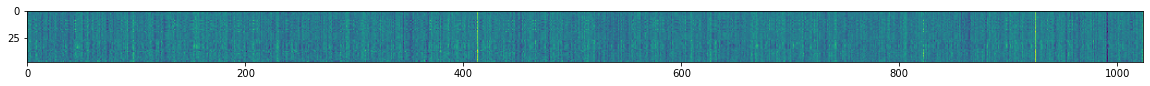

In [12]:
plt.figure(figsize=(20,10))
plt.imshow(doc_embeddings)

47


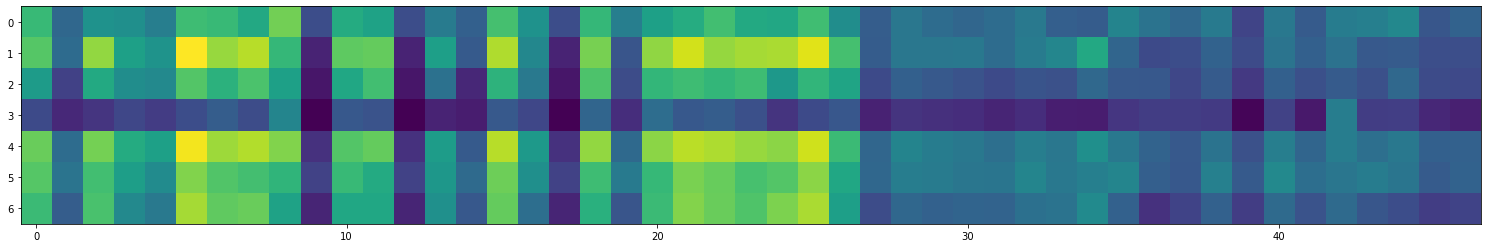

In [13]:
X = doc_embeddings
distance_matrix = pairwise_distances(X, centroids, metric='cosine', n_jobs=1)
# distance_matrix = relu ( ((distance_matrix * -1)+1) , _mx-0.01)

distance_matrix = (distance_matrix * -1)+1.0
distance_matrix = distance_matrix.T
plt.figure(figsize=(30,4))
plt.imshow( distance_matrix )
# plt.plot(np.array(distance_matrix.T[0]))
print(len(distance_matrix[0]))

In [14]:
# sample_doc.sentence_map.remap_span((0,1), sample_doc.tokens_map)
# sample_doc.attributes_tree.__dict__ #['attributes_tree']
sample_j_doc.analysis['attributes_tree']

{'contract': {'orgs': [{'type': {'confidence': 0.9581671357154846,
     'value': 'Акционерное общество',
     'kind': 'org-1-type',
     'span': [23, 25],
     'span_map': 'words'},
    'name': {'confidence': 0.5242518782615662,
     'value': 'Реестр',
     'kind': 'org-1-name',
     'span': [25, 28],
     'span_map': 'words'},
    'alias': {'confidence': 0.6145750880241394,
     'value': 'Регистратор',
     'kind': 'org-1-alias',
     'span': [50, 51],
     'span_map': 'words'},
    'is_known_subsidiary': False},
   {'alias': {'confidence': 0.5386344194412231,
     'value': 'Эмитент',
     'kind': 'org-2-alias',
     'span': [76, 77],
     'span_map': 'words'},
    'is_known_subsidiary': False}],
  'subject': {'confidence': 0.6816461086273193,
   'value': 'Service',
   'span': [110, 197],
   'span_map': 'words'},
  'number': {'confidence': 0.6434124112129211,
   'value': '___',
   'kind': 'number',
   'span': [1, 3],
   'span_map': 'words'}}}

In [15]:
# sample_doc.attributes_tree = *sample_j_doc.analysis['attributes_tree']
sample_doc.attributes_tree.__dict__.update(sample_j_doc.analysis['attributes_tree']['contract'])


threshold 0.8

--------------------
--------------------
1=cluster 	 0.8877407312393188=similarity, 
 1. Эмитент поручает, а Регистратор принимает на себя за вознаграждение обязательство по ведению и хранению реестра владельцев ценных бумаг Эмитента, в соответствии с требованиями законодательства Российской Федерации, положениями Типовых условий взаимодействия Регистратора и Эмитента по договору на ведение реестра владельцев ценных бумаг (далее - «Типовые» условия) и настоящего Договора. 
span (chars): (584, 974) (107, 165)
SemanticTag: insideInformation (107, 165) Unknown 0.8877407312393188
--------------------
--------------------
--------------------
--------------------
--------------------
0.88774073 1


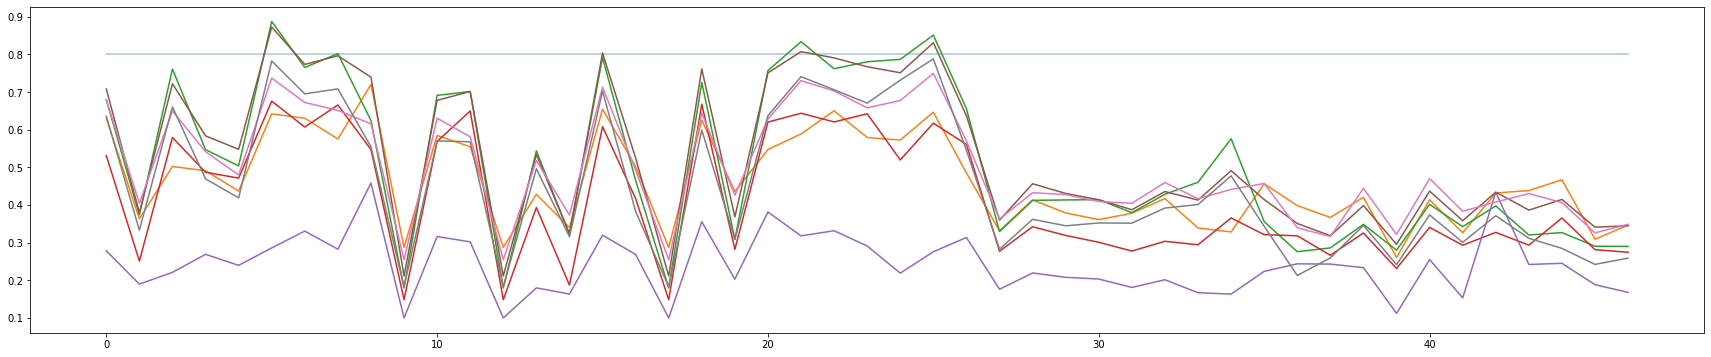

In [16]:
from analyser.ml_tools import SemanticTag

eps = 0.01
threshold = 0.8 #0.9 *  distance_matrix.max()
print('threshold', threshold)
print()
sim_max = threshold
i_max = 0
plt.figure(figsize=(30,6))
plt.plot([threshold]*len(sample_doc.sentence_map), alpha=0.4 )
for k in range(n_clusters):    
    print('-'*20)
 
    av = distance_matrix[k]  #relu(v, threshold) ## attention vector
    
    ii = av.argmax()
    
    
 
    plt.plot(av)
#     if (sim > threshold):
        
#         print (sample_doc.tokens_map.tokens[_span[0]:_span[1]  ] )
        
        
    if av[ii] > sim_max:
        print( f"{k}=cluster \t {av[ii]}=similarity, \n {sample_doc.sentence_map.tokens[ii]} ")
        char_span =  sample_doc.sentence_map.map[ii]
        
        
        _span = sample_doc.sentence_map.remap_span((ii, ii+1), sample_doc.tokens_map)
        print("span (chars):", char_span, _span)
        tag = SemanticTag( 'insideInformation','Unknown', span=_span, confidence=np.float(av[ii]))
        print(tag)
        
        i_max = k
        sim_max = av[ii]
        
        setattr(sample_doc.attributes_tree, "insideInformation", tag)
        
print(sim_max, i_max)

# t_span = source_map.remap_span(span, target_map)

In [17]:
sample_doc.attributes_tree.__dict__

{'orgs': [{'type': {'confidence': 0.9581671357154846,
    'value': 'Акционерное общество',
    'kind': 'org-1-type',
    'span': [23, 25],
    'span_map': 'words'},
   'name': {'confidence': 0.5242518782615662,
    'value': 'Реестр',
    'kind': 'org-1-name',
    'span': [25, 28],
    'span_map': 'words'},
   'alias': {'confidence': 0.6145750880241394,
    'value': 'Регистратор',
    'kind': 'org-1-alias',
    'span': [50, 51],
    'span_map': 'words'},
   'is_known_subsidiary': False},
  {'alias': {'confidence': 0.5386344194412231,
    'value': 'Эмитент',
    'kind': 'org-2-alias',
    'span': [76, 77],
    'span_map': 'words'},
   'is_known_subsidiary': False}],
 'subject': {'confidence': 0.6816461086273193,
  'value': 'Service',
  'span': [110, 197],
  'span_map': 'words'},
 'number': {'confidence': 0.6434124112129211,
  'value': '___',
  'kind': 'number',
  'span': [1, 3],
  'span_map': 'words'},
 'insideInformation': <analyser.ml_tools.SemanticTag at 0x16b1a7490>}

In [18]:
from analyser.runner import save_analysis 

save_analysis(sample_j_doc, sample_doc, state = sample_j_doc.state )

INFO:gpn:model_checkpoint_path: /Users/artem/work/nemo/analyser/analyser/vocab
INFO:gpn:weights loaded: /Users/artem/work/nemo/analyser/analyser/vocab/uber_detection_model_005_1_1-2.5.0.h5


Model: "uber_detection_model_005_1_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_text_emb (InputLayer)     [(None, None, 1024)] 0                                            
__________________________________________________________________________________________________
drops (Dropout)                 (None, None, 1024)   0           input_text_emb[0][0]             
__________________________________________________________________________________________________
input_headlines_att (InputLayer [(None, None, 15)]   0                                            
__________________________________________________________________________________________________
concatenate (Concatenate)       (None, None, 1039)   0           drops[0][0]                      
                                                                 input_

/Users/artem/work/nemo/analyser/integration/db.py:12: UserWarning: MongoDB : define GPN_DB_NAME environment variable! defaulting to gpn
  warnings.warn(msg)


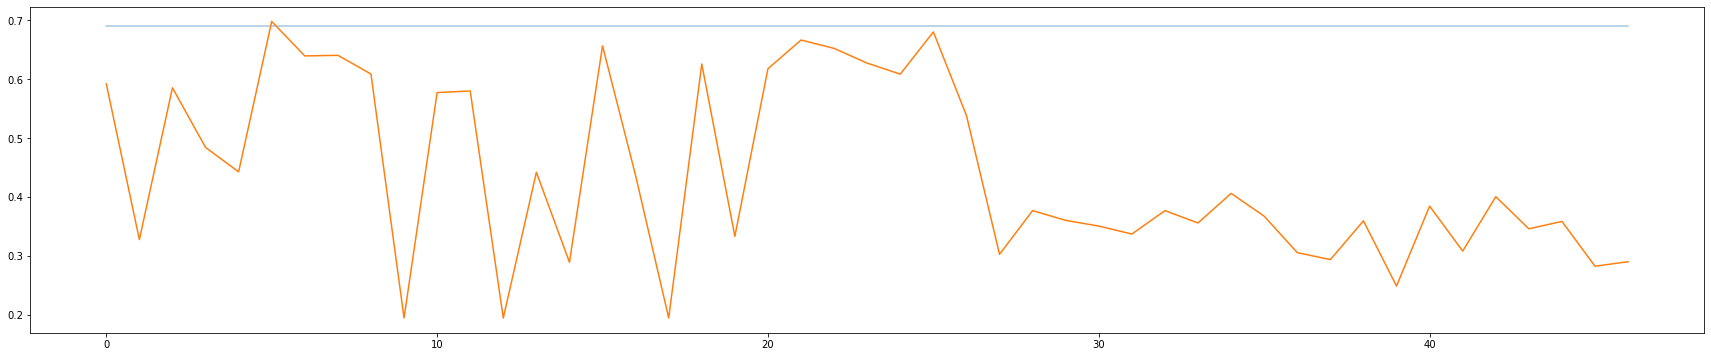

In [19]:
plt.figure(figsize=(30,6))
relu_threshold =  distance_matrix.mean(axis=0).max()*0.99
plt.plot([relu_threshold]*len(sample_doc.sentence_map), alpha=0.4 )
plt.plot(distance_matrix.mean(axis=0))

In [20]:
from colab_support.renderer import HtmlRenderer
import matplotlib as matplotlib
from IPython.core.display import display, HTML

class DemoRenderer(HtmlRenderer):
  def render_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    html = self.to_color_text(tokens, weights, colormap, print_debug, _range, separator=separator)
    display(HTML(html))

  def to_color_text(self, tokens, weights, colormap='coolwarm', print_debug=False, _range=None, separator=' '):
    return super()._to_color_text(tokens, weights, matplotlib, colormap=colormap, _range=_range, separator=separator)

renderer_ = DemoRenderer()


renderer_.render_color_text(sample_doc.sentence_map.tokens, relu(distance_matrix.mean(axis=0), relu_threshold), _range=(0,1))

NameError: name 'relu' is not defined